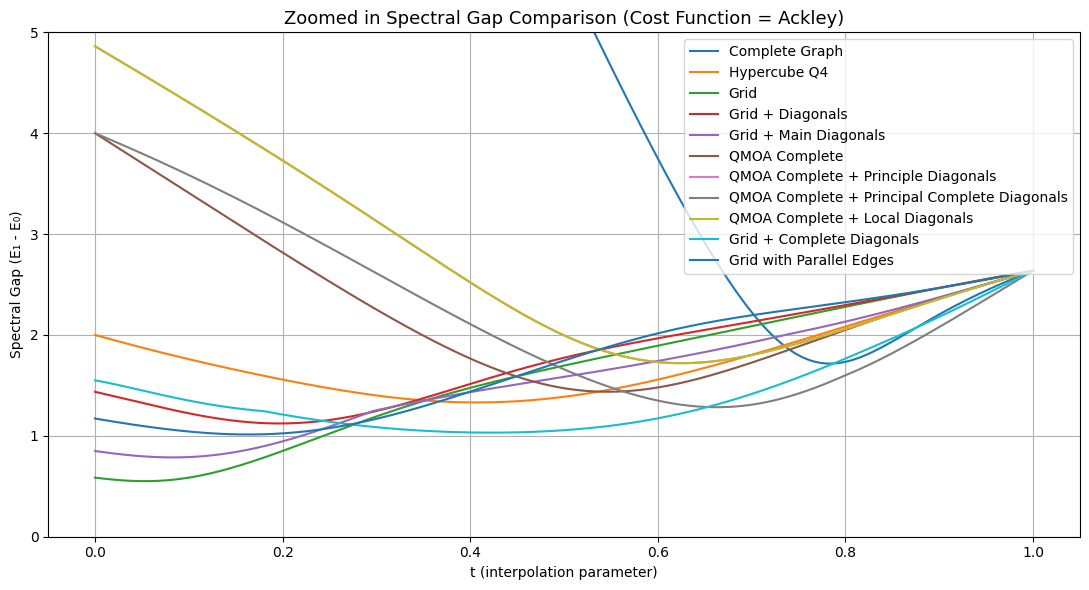

In [16]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 4, 4
n = rows * cols  # Number of nodes

# === Ackley Cost Function ===
def ackley(x, y):
    a, b, c = 20, 0.2, 2 * np.pi
    x, y = np.array(x), np.array(y)
    sum_sq = 0.5 * (x ** 2 + y ** 2)
    cos_comp = 0.5 * (np.cos(c * x) + np.cos(c * y))
    return -a * np.exp(-b * np.sqrt(sum_sq)) - np.exp(cos_comp) + a + np.exp(1)

# Build H_C diagonal
costs = [ackley(i, j) for i in range(rows) for j in range(cols)]
H_C = np.diag(costs)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete_with_local_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # Fully connect rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # Fully connect columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add LOCAL diagonals (nearest neighbors)
    for r in range(rows - 1):
        for c in range(cols - 1):
            G.add_edge((r, c), (r + 1, c + 1))
            G.add_edge((r + 1, c), (r, c + 1))
    return nx.convert_node_labels_to_integers(G, ordering="sorted")

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q4": nx.convert_node_labels_to_integers(nx.hypercube_graph(4)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + Principle Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "QMOA Complete + Local Diagonals": build_qmoa_complete_with_local_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title("Zoomed in Spectral Gap Comparison (Cost Function = Ackley)", fontsize=13)
plt.grid(True)
plt.ylim(0, 5)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
print(len(G.nodes))
print(H_C.shape)

16
(16, 16)


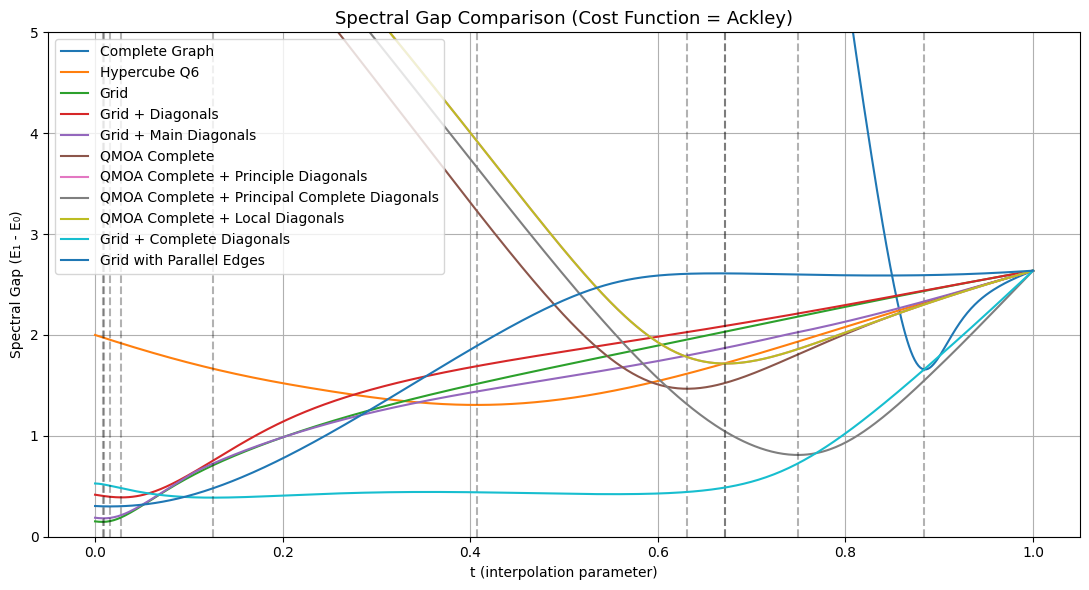


=== Minimum Gap Results (Ackley) ===
Graph                                         |    s* |    Gap
-----------------------------------------------------------------
Complete Graph                                | 0.884 |  1.658
Hypercube Q6                                  | 0.407 |  1.306
Grid                                          | 0.008 |  0.147
Grid + Diagonals                              | 0.028 |  0.390
Grid + Main Diagonals                         | 0.010 |  0.183
QMOA Complete                                 | 0.631 |  1.467
QMOA Complete + Principle Diagonals           | 0.671 |  1.716
QMOA Complete + Principal Complete Diagonals  | 0.749 |  0.811
QMOA Complete + Local Diagonals               | 0.671 |  1.716
Grid + Complete Diagonals                     | 0.126 |  0.387
Grid with Parallel Edges                      | 0.016 |  0.300


In [19]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 8, 8
n = rows * cols  # 64 nodes

# === Ackley Cost Function ===
def ackley(x, y):
    a, b, c = 20, 0.2, 2 * np.pi
    sum_sq = 0.5 * (x ** 2 + y ** 2)
    cos_comp = 0.5 * (np.cos(c * x) + np.cos(c * y))
    return -a * np.exp(-b * np.sqrt(sum_sq)) - np.exp(cos_comp) + a + np.exp(1)

# Build H_C diagonal
costs = [ackley(i, j) for i in range(rows) for j in range(cols)]
H_C = np.diag(costs)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []
    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, np.array(gap_vals)

# === Graph Constructors (same as your code) ===
def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))
# (other build_xxx graph constructors remain the same…)


def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete_with_local_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # Fully connect rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # Fully connect columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add LOCAL diagonals (nearest neighbors)
    for r in range(rows - 1):
        for c in range(cols - 1):
            G.add_edge((r, c), (r + 1, c + 1))
            G.add_edge((r + 1, c), (r, c + 1))
    return nx.convert_node_labels_to_integers(G, ordering="sorted")

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)
# … include all graph constructors here …

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q6": nx.convert_node_labels_to_integers(nx.hypercube_graph(6)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + Principle Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "QMOA Complete + Local Diagonals": build_qmoa_complete_with_local_diagonals(rows, cols),
    "Grid + Complete Diagonals": build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted multigraph
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps with vertical lines at s* ===
plt.figure(figsize=(11, 6))
results = []

for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue

    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

    # Find minimum gap
    idx = np.argmin(gap_vals)
    s_star = t_vals[idx]
    min_gap = gap_vals[idx]
    results.append((name, s_star, min_gap))

    # Add vertical dashed line
    plt.axvline(x=s_star, color='k', linestyle='--', alpha=0.3)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title("Spectral Gap Comparison (Cost Function = Ackley)", fontsize=13)
plt.grid(True)
plt.ylim(0,5)
plt.legend()
plt.tight_layout()
plt.show()

# === Print table of minimum gaps ===
print("\n=== Minimum Gap Results (Ackley) ===")
print(f"{'Graph':45s} | {'s*':>5s} | {'Gap':>6s}")
print("-"*65)
for name, s_star, min_gap in results:
    print(f"{name:45s} | {s_star:5.3f} | {min_gap:6.3f}")

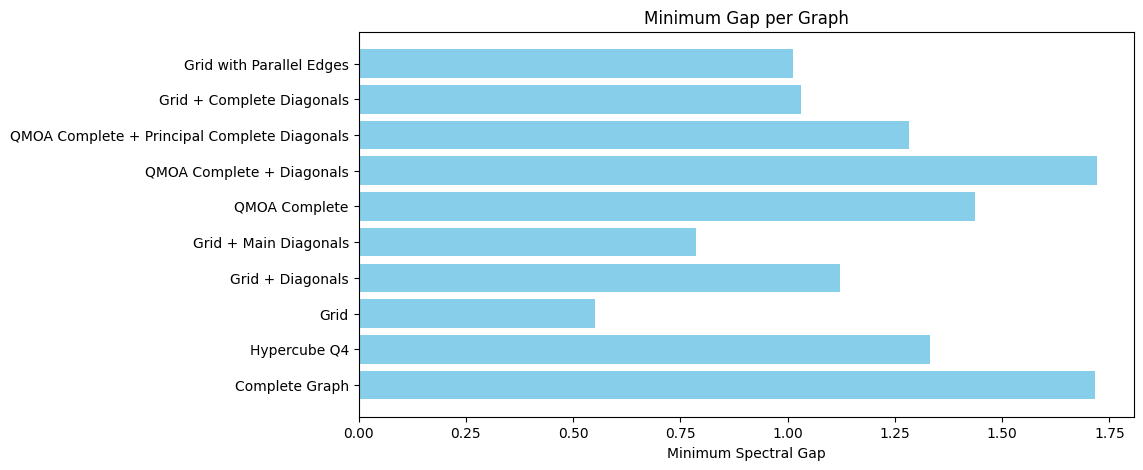

In [5]:
import matplotlib.pyplot as plt

# Suppose you stored results as a dict:
# results[name] = {"s*": s_star, "gap": min_gap, "ent": ent, "ghz": ghz_ov, "w": w_ov}

graph_names = list(results.keys())
gaps = [results[g]['gap'] for g in graph_names]

plt.figure(figsize=(10,5))
plt.barh(graph_names, gaps, color='skyblue')
plt.xlabel("Minimum Spectral Gap")
plt.title("Minimum Gap per Graph")
plt.show()

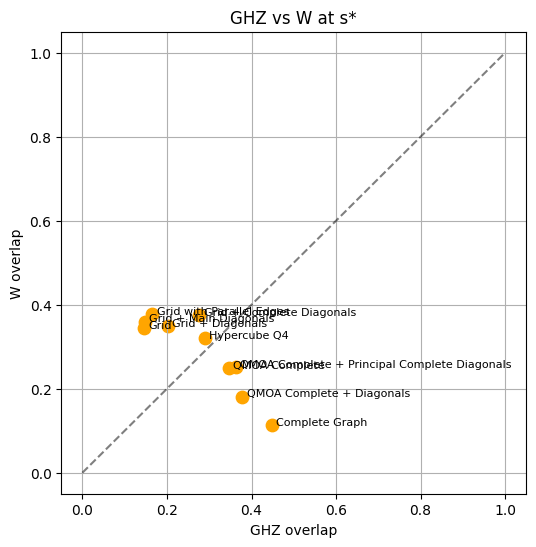

In [6]:
ghz_vals = [results[g]['ghz'] for g in graph_names]
w_vals = [results[g]['w'] for g in graph_names]

plt.figure(figsize=(6,6))
plt.scatter(ghz_vals, w_vals, s=80, c='orange')
for i, g in enumerate(graph_names):
    plt.text(ghz_vals[i]+0.01, w_vals[i], g, fontsize=8)
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel("GHZ overlap")
plt.ylabel("W overlap")
plt.title("GHZ vs W at s*")
plt.grid(True)
plt.show()

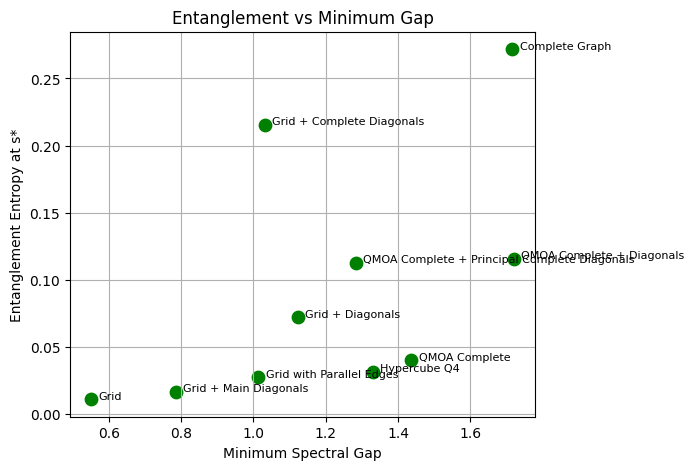

In [44]:
ent_vals = [results[g]['ent'] for g in graph_names]

plt.figure(figsize=(6,5))
plt.scatter(gaps, ent_vals, s=80, c='green')
for i, g in enumerate(graph_names):
    plt.text(gaps[i]+0.02, ent_vals[i], g, fontsize=8)
plt.xlabel("Minimum Spectral Gap")
plt.ylabel("Entanglement Entropy at s*")
plt.title("Entanglement vs Minimum Gap")
plt.grid(True)
plt.show()

In [28]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from itertools import combinations

rows, cols = 2, 2
n = rows * cols

# Ackley cost function
def ackley(x, y):
    a, b, c = 20, 0.2, 2 * np.pi
    sum_sq = 0.5 * (x ** 2 + y ** 2)
    cos_comp = 0.5 * (np.cos(c * x) + np.cos(c * y))
    return -a * np.exp(-b * np.sqrt(sum_sq)) - np.exp(cos_comp) + a + np.exp(1)

costs = [ackley(i, j) for i in range(rows) for j in range(cols)]
H_C = np.diag(costs)

# Functions for entanglement
def entanglement_entropy(statevector):
    """Von Neumann entropy of bipartition (half-half)"""
    dim = len(statevector)
    n_qubits = int(np.log2(dim))
    dim_A = 2**(n_qubits//2)
    dim_B = 2**(n_qubits - n_qubits//2)
    psi = statevector.reshape(dim_A, dim_B)
    rho_A = psi @ psi.conj().T
    eigvals = np.linalg.eigvalsh(rho_A)
    eigvals = eigvals[eigvals > 1e-12]
    return -np.sum(eigvals * np.log2(eigvals))

def ghz_state(n_qubits):
    dim = 2**n_qubits
    v = np.zeros(dim, dtype=complex)
    v[0] = v[-1] = 1/np.sqrt(2)
    return v

def w_state(n_qubits):
    dim = 2**n_qubits
    v = np.zeros(dim, dtype=complex)
    for i in range(n_qubits):
        v[1<<i] = 1/np.sqrt(n_qubits)
    return v

def state_overlap(psi, phi):
    return np.abs(np.vdot(phi, psi))**2

# Spectral gap
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape
    t_vals = np.linspace(0, 1, 200)
    gaps, ground_states = [], []
    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        evals, evecs = eigh(H_t)
        gaps.append(evals[1] - evals[0])
        ground_states.append(evecs[:, 0])
    return t_vals, np.array(gaps), ground_states

# Graph definitions (reuse your functions)

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))
# (other build_xxx graph constructors remain the same…)


def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")

def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete_with_local_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # Fully connect rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # Fully connect columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add LOCAL diagonals (nearest neighbors)
    for r in range(rows - 1):
        for c in range(cols - 1):
            G.add_edge((r, c), (r + 1, c + 1))
            G.add_edge((r + 1, c), (r, c + 1))
    return nx.convert_node_labels_to_integers(G, ordering="sorted")


def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)
# … include all graph constructors here …

# ... include all build_xxx functions as before ...

graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q6": nx.convert_node_labels_to_integers(nx.hypercube_graph(6)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + Principle Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "QMOA Complete + Local Diagonals": build_qmoa_complete_with_local_diagonals(rows, cols),
    "Grid + Complete Diagonals": build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted multigraph
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# Compute entanglement structure at s*
print("=== Minimum gap entanglement structure (Ackley) ===")
print(f"{'Graph':35s} | {'s*':^5s} | {'Gap':^6s} | {'Ent':^6s} | {'GHZ':^6s} | {'W':^6s}")
print("-"*80)
results = {}

for name, G in graphs.items():
    if len(G.nodes) != n:
        continue
    t_vals, gap_vals, gs_list = compute_spectral_gap(G)
    idx = np.argmin(gap_vals)
    s_star = t_vals[idx]
    min_gap = gap_vals[idx]
    gs_star = gs_list[idx]

    # Compute entanglement metrics
    ent = entanglement_entropy(gs_star)
    n_qubits = int(np.log2(len(gs_star)))
    ghz_ov = state_overlap(gs_star, ghz_state(n_qubits))
    w_ov = state_overlap(gs_star, w_state(n_qubits))

    results[name] = {
        "s*": s_star,
        "gap": min_gap,
        "ent": ent,
        "ghz": ghz_ov,
        "w": w_ov,
        "gs": gs_star}

    print(f"{name:35s} | {s_star:5.2f} | {min_gap:6.3f} | {ent:6.3f} | {ghz_ov:6.3f} | {w_ov:6.3f}")

=== Minimum gap entanglement structure (Ackley) ===
Graph                               |  s*   |  Gap   |  Ent   |  GHZ   |   W   
--------------------------------------------------------------------------------
Complete Graph                      |  0.61 |  1.646 |  0.110 |  0.620 |  0.152
Grid                                |  0.40 |  1.381 |  0.015 |  0.537 |  0.292
Grid + Diagonals                    |  0.61 |  1.646 |  0.110 |  0.620 |  0.152
Grid + Main Diagonals               |  0.61 |  1.646 |  0.110 |  0.620 |  0.152
QMOA Complete                       |  0.40 |  1.381 |  0.015 |  0.537 |  0.292
QMOA Complete + Principle Diagonals |  0.61 |  1.646 |  0.110 |  0.620 |  0.152
QMOA Complete + Principal Complete Diagonals |  0.61 |  1.646 |  0.110 |  0.620 |  0.152
QMOA Complete + Local Diagonals     |  0.61 |  1.646 |  0.110 |  0.620 |  0.152
Grid + Complete Diagonals           |  0.61 |  1.646 |  0.110 |  0.620 |  0.152
Grid with Parallel Edges            |  0.65 |  1.914 |  0.

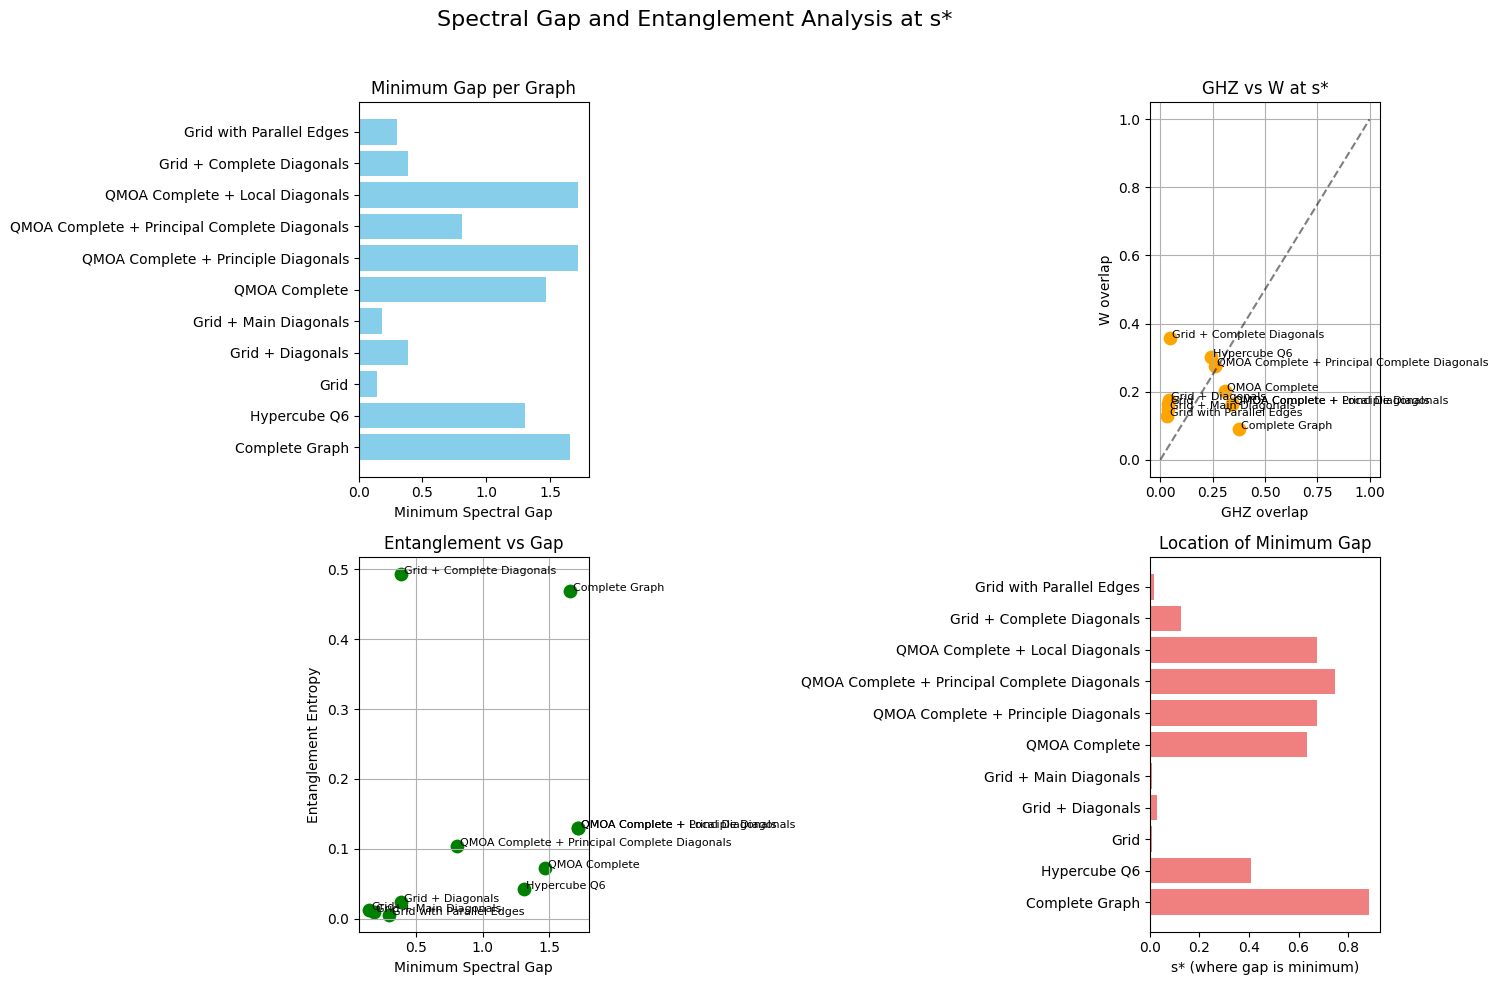

In [22]:
import matplotlib.pyplot as plt

# Assuming you already have `results` as:
# results[name] = {"s*": s_star, "gap": min_gap, "ent": ent,
#                  "ghz": ghz_ov, "w": w_ov}

graph_names = list(results.keys())
gaps = [results[g]['gap'] for g in graph_names]
s_vals = [results[g]['s*'] for g in graph_names]
ent_vals = [results[g]['ent'] for g in graph_names]
ghz_vals = [results[g]['ghz'] for g in graph_names]
w_vals = [results[g]['w'] for g in graph_names]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Spectral Gap and Entanglement Analysis at s*", fontsize=16)

# --- Plot 1: Minimum Spectral Gap (horizontal bar) ---
axs[0, 0].barh(graph_names, gaps, color='skyblue')
axs[0, 0].set_xlabel("Minimum Spectral Gap")
axs[0, 0].set_title("Minimum Gap per Graph")

# --- Plot 2: GHZ vs W Overlap ---
axs[0, 1].scatter(ghz_vals, w_vals, s=80, c='orange')
for i, g in enumerate(graph_names):
    axs[0, 1].text(ghz_vals[i]+0.01, w_vals[i], g, fontsize=8)
axs[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axs[0, 1].set_xlabel("GHZ overlap")
axs[0, 1].set_ylabel("W overlap")
axs[0, 1].set_title("GHZ vs W at s*")
axs[0, 1].grid(True)

# --- Plot 3: Entropy vs Gap ---
axs[1, 0].scatter(gaps, ent_vals, s=80, c='green')
for i, g in enumerate(graph_names):
    axs[1, 0].text(gaps[i]+0.02, ent_vals[i], g, fontsize=8)
axs[1, 0].set_xlabel("Minimum Spectral Gap")
axs[1, 0].set_ylabel("Entanglement Entropy")
axs[1, 0].set_title("Entanglement vs Gap")
axs[1, 0].grid(True)

# --- Plot 4: s* Values ---
axs[1, 1].barh(graph_names, s_vals, color='lightcoral')
axs[1, 1].set_xlabel("s* (where gap is minimum)")
axs[1, 1].set_title("Location of Minimum Gap")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

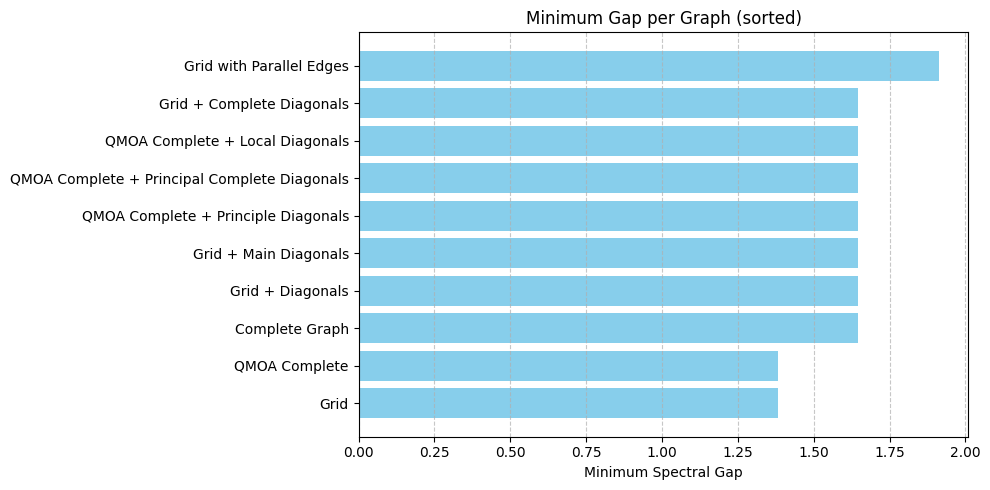

In [29]:
import matplotlib.pyplot as plt

# Sort the results by the minimum spectral gap
sorted_items = sorted(results.items(), key=lambda x: x[1]['gap'])

graph_names = [k for k, v in sorted_items]
gaps = [v['gap'] for k, v in sorted_items]

plt.figure(figsize=(10, 5))
plt.barh(graph_names, gaps, color='skyblue')
plt.xlabel("Minimum Spectral Gap")
plt.title("Minimum Gap per Graph (sorted)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

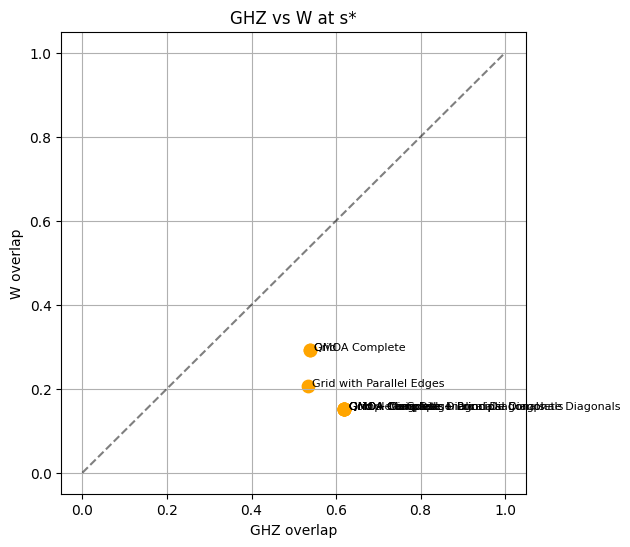

In [30]:
ghz_vals = [results[g]['ghz'] for g in graph_names]
w_vals = [results[g]['w'] for g in graph_names]

plt.figure(figsize=(6,6))
plt.scatter(ghz_vals, w_vals, s=80, c='orange')
for i, g in enumerate(graph_names):
    plt.text(ghz_vals[i]+0.01, w_vals[i], g, fontsize=8)
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel("GHZ overlap")
plt.ylabel("W overlap")
plt.title("GHZ vs W at s*")
plt.grid(True)
plt.show()

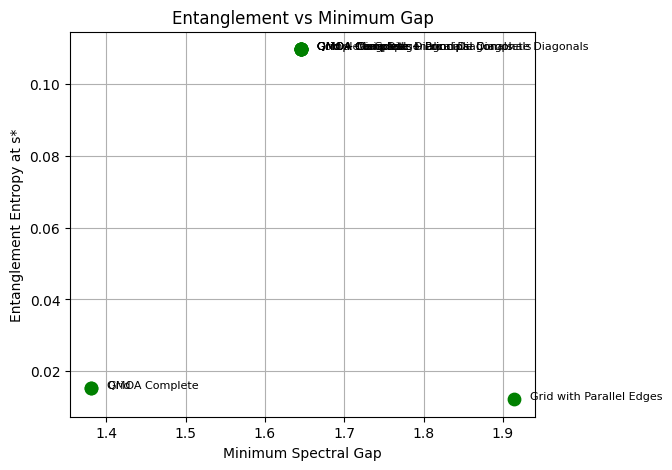

In [31]:
ent_vals = [results[g]['ent'] for g in graph_names]

plt.figure(figsize=(6,5))
plt.scatter(gaps, ent_vals, s=80, c='green')
for i, g in enumerate(graph_names):
    plt.text(gaps[i]+0.02, ent_vals[i], g, fontsize=8)
plt.xlabel("Minimum Spectral Gap")
plt.ylabel("Entanglement Entropy at s*")
plt.title("Entanglement vs Minimum Gap")
plt.grid(True)
plt.show()

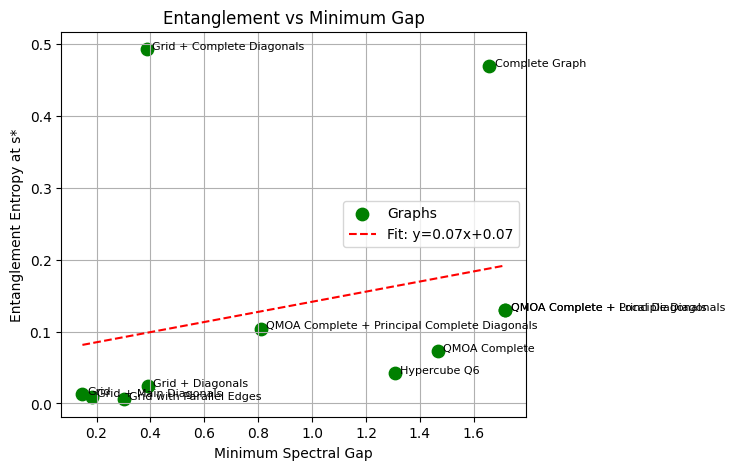

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Extract data
ent_vals = [results[g]['ent'] for g in graph_names]

# Scatter plot
plt.figure(figsize=(6,5))
plt.scatter(gaps, ent_vals, s=80, c='green', label='Graphs')

# Add labels to each point
for i, g in enumerate(graph_names):
    plt.text(gaps[i]+0.02, ent_vals[i], g, fontsize=8)

# Fit a line (linear regression)
coeffs = np.polyfit(gaps, ent_vals, deg=1)
poly = np.poly1d(coeffs)
x_fit = np.linspace(min(gaps), max(gaps), 100)
y_fit = poly(x_fit)

plt.plot(x_fit, y_fit, 'r--', label=f'Fit: y={coeffs[0]:.2f}x+{coeffs[1]:.2f}')

# Labels and title
plt.xlabel("Minimum Spectral Gap")
plt.ylabel("Entanglement Entropy at s*")
plt.title("Entanglement vs Minimum Gap")
plt.grid(True)
plt.legend()
plt.show()

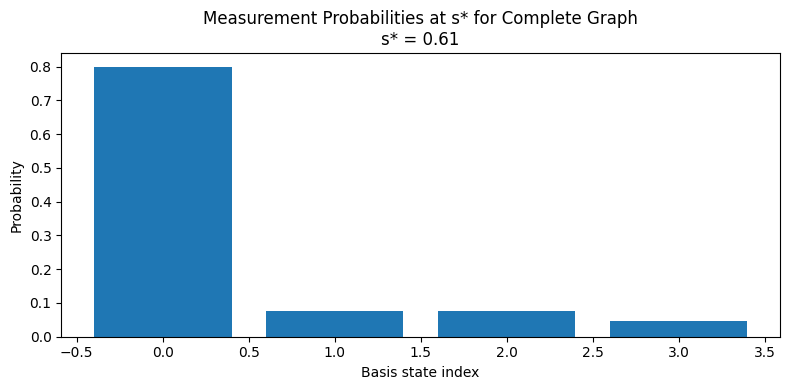

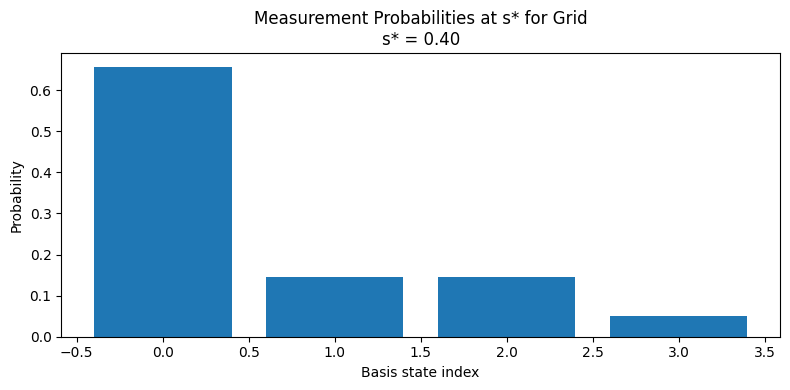

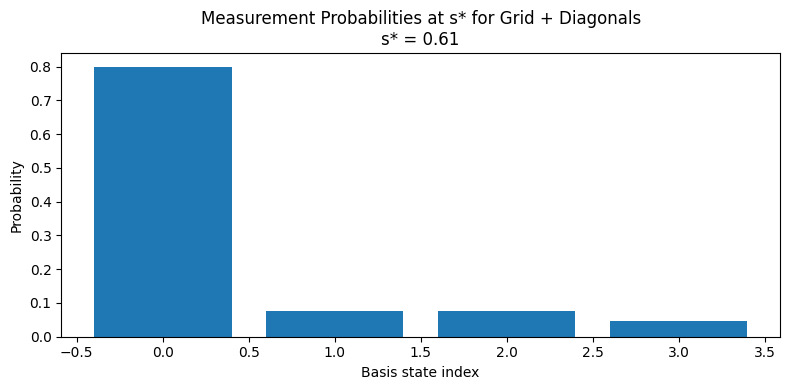

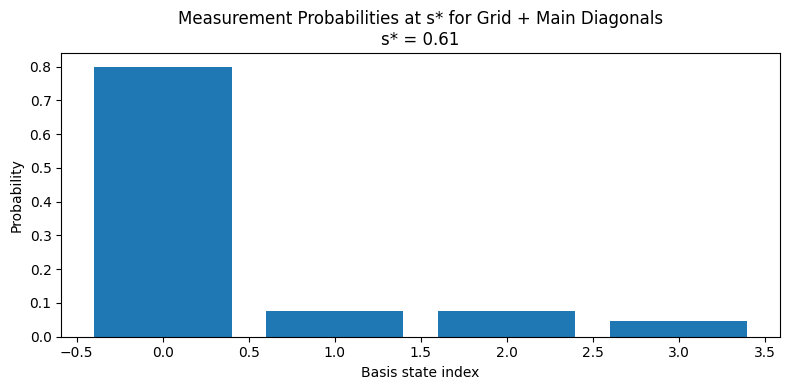

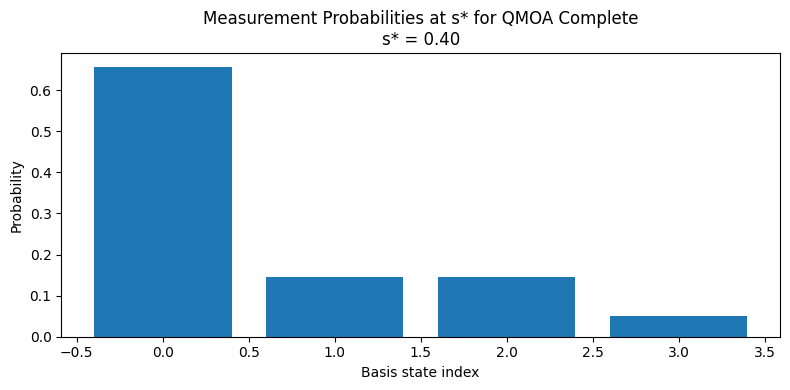

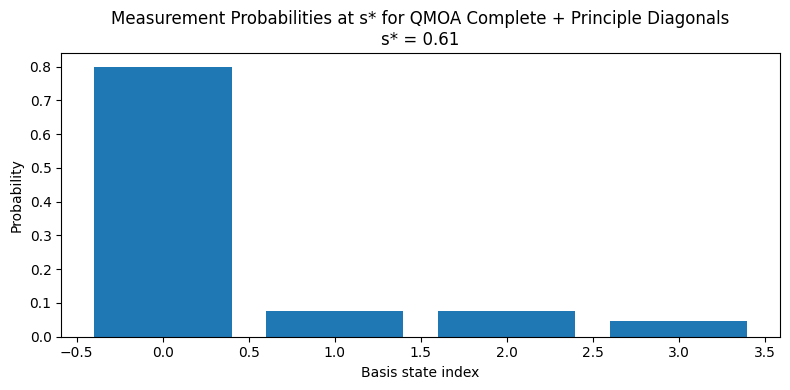

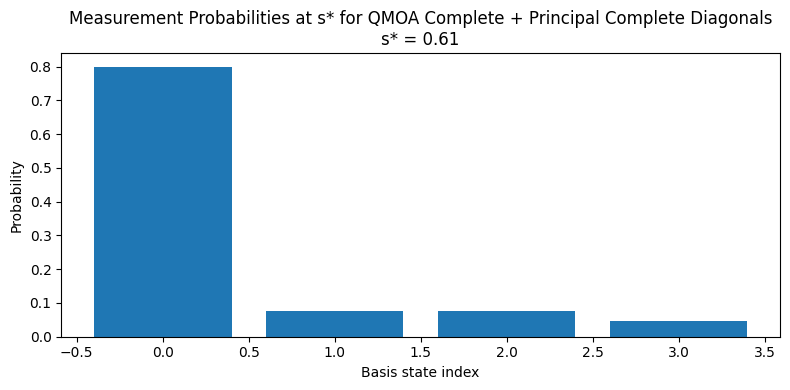

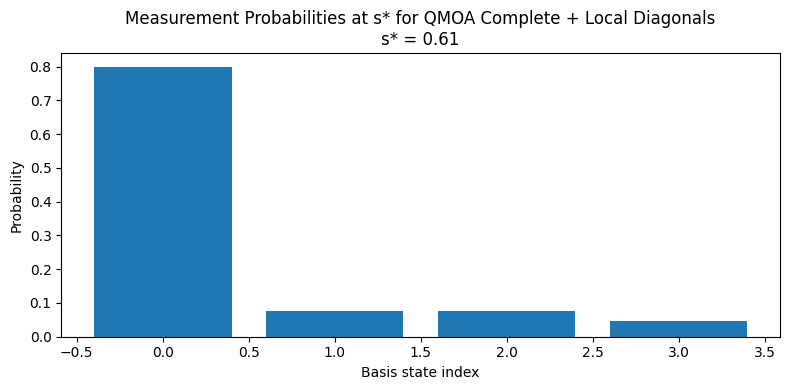

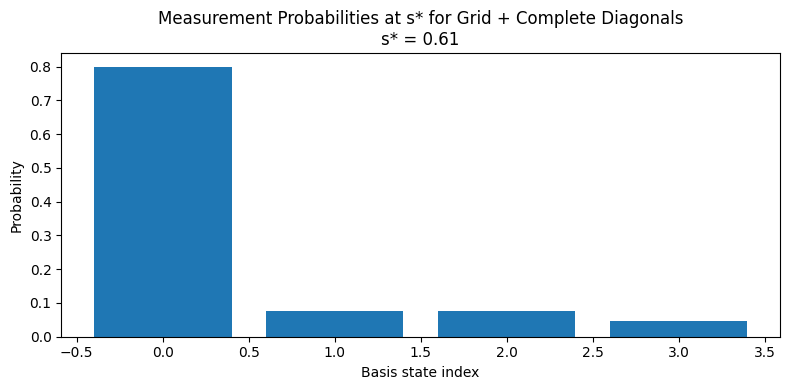

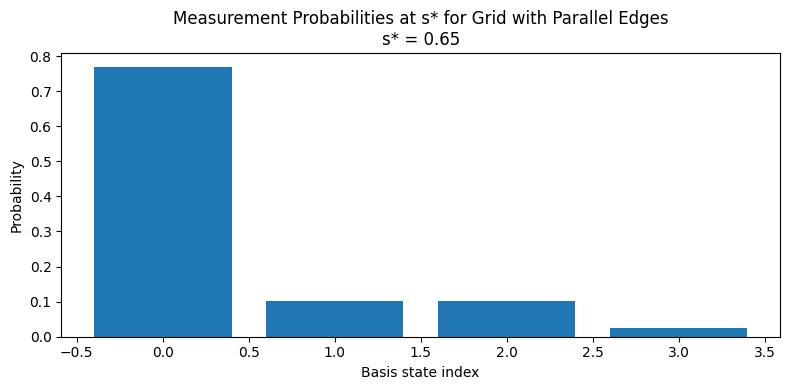

In [32]:
import numpy as np
import matplotlib.pyplot as plt

for name, G in graphs.items():
    if len(G.nodes) != n:
        continue

    # Compute spectral gap and ground states
    t_vals, gap_vals, gs_list = compute_spectral_gap(G)
    idx = np.argmin(gap_vals)
    s_star = t_vals[idx]
    gs_star = gs_list[idx]   # Ground state at minimal gap

    # Compute probabilities
    probs = np.abs(gs_star)**2

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(probs)), probs)
    plt.title(f"Measurement Probabilities at s* for {name}\ns* = {s_star:.2f}")
    plt.xlabel("Basis state index")
    plt.ylabel("Probability")
    plt.tight_layout()
    plt.show()

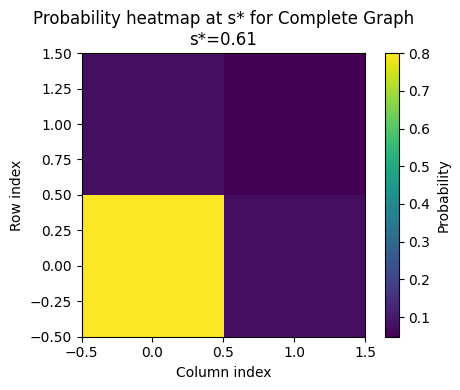

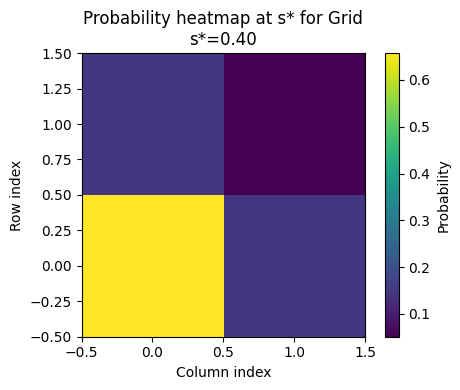

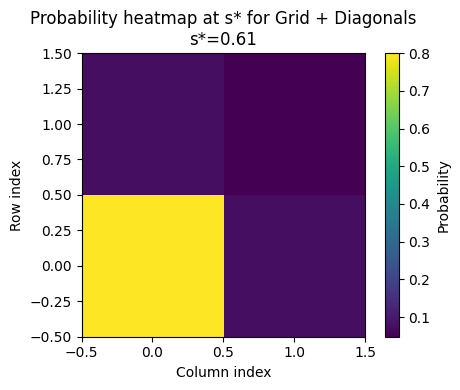

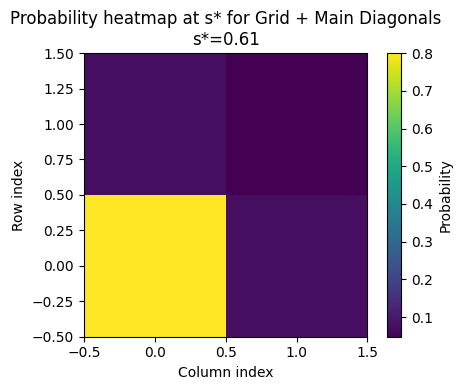

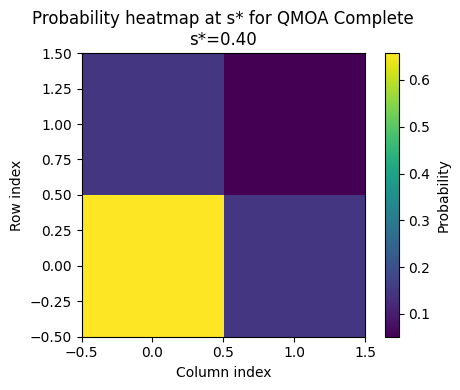

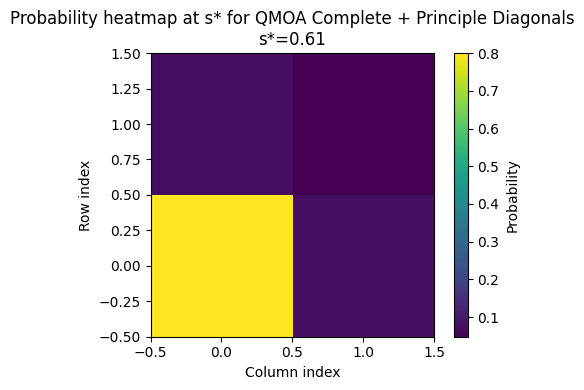

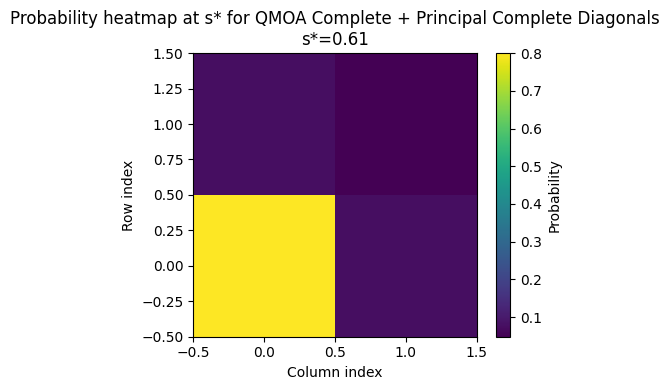

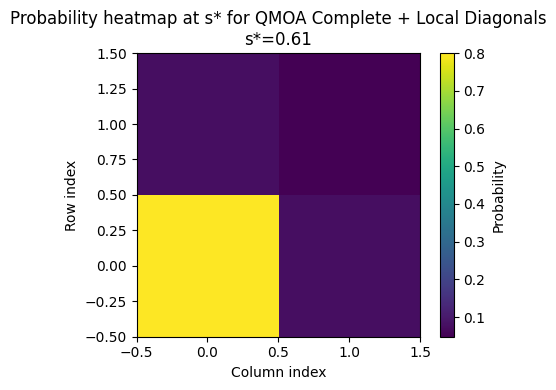

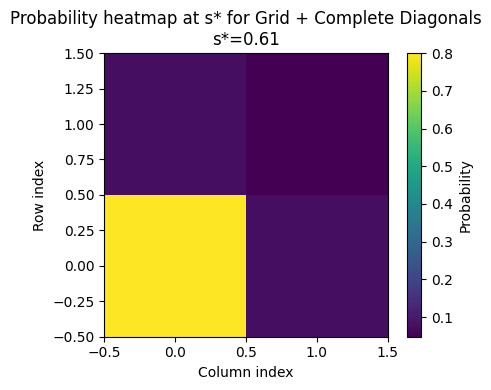

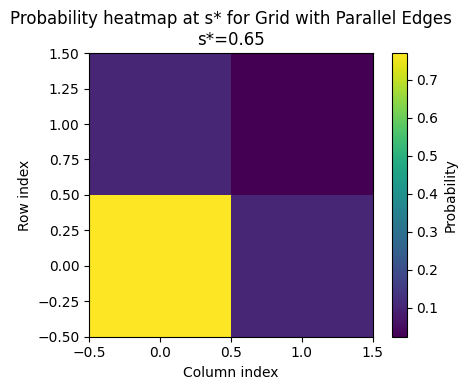

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def plot_prob_heatmap(gs_star, rows, cols, title):
    # Compute probabilities
    probs = np.abs(gs_star)**2
    # Reshape (important: the ground state ordering is by node index)
    grid_probs = probs.reshape((rows, cols))
    
    plt.figure(figsize=(5, 4))
    plt.imshow(grid_probs, cmap='viridis', origin='lower')
    plt.colorbar(label="Probability")
    plt.title(title)
    plt.xlabel("Column index")
    plt.ylabel("Row index")
    plt.tight_layout()
    plt.show()

# Loop over graphs and plot
for name, G in graphs.items():
    if len(G.nodes) != n:
        continue

    t_vals, gap_vals, gs_list = compute_spectral_gap(G)
    idx = np.argmin(gap_vals)
    s_star = t_vals[idx]
    gs_star = gs_list[idx]

    plot_prob_heatmap(gs_star, rows, cols,
                      f"Probability heatmap at s* for {name}\ns*={s_star:.2f}")